# CogSci 127 Final Project: Image Reconstruction

## Introduction

The purpose of this project was to explore the effectiveness of encoding/decoding models with regards to fMRI scans. More specifically, given a list of scans of patients who were viewing images, can we deduce what they saw only by looking at the scan? While this has been investigated already, this project is novel because the dataset included fMRI scans of patients who not only saw images, but imagined them as well. If we can apply an effective encoder on the thought images, then we would effectively be able to read someone's mind. This can possibly aid with the effort to decode dreams as well [8].

## Background

There has been a lot of work done with regards to not only brain decoding, but image reconstruction in general [2, 3, 4, 5, 6, 7]. Among the various methods use to create decodres are Support Vector Machines (SVMs), Deep Neural Nets (DNNs), Convolutional Neural Nets (CNNs), Generalized Linear Models (GLMs) and dimensionality reductions (PCA, ICA) [9, 10]. While the former examples are definitely more robust, I was fascinated by the results Jack got by simpling using PCA. While it is an effective tool, it tends to be susceptible to more noise, however the examples he went through in class showed that he actually got results. This, in combination with the fact that PCA is the least computationally expensive, led me to pursue PCA as my form of building a decoder.

## Method and Dataset Description

The dataset was gathered from a study by Horikawa, T. & Kamitani, Y. (2017), found here: https://openneuro.org/datasets/ds001246/versions/1.0.1. They got 5 subjects, placed them in an MRI over several sessions, and gathered 3 datasets: a training imaging dataset where the subject was shown a total of 1,200 images from 150 object categories (8 images from each category) where each was presented only once (24 runs). The images were presented in 9 second intervals, with repititions interleaved (5 per run). In the test image dataset, a total of 50 images from 50 object categories (1 image from each category) were presented 35 times each (35 runs). Lastly, the "imagination set" had the subjects visually imagine images from 1 of the 50 categories (20 runs; 25 categories in each run; 10 samples for each category) that were presented in the test image session of the image presentation experiment. 

The fMRI scans had the following specs: for the functional scans, the repitition time (TR) was 3000 ms; TE, 30 ms; flip angle, 80°; voxel size, 3 × 3 × 3 mm; FOV, 192 × 192 mm; number of slices, 50, slice gap, 0 mm. For the anatomical scans, there were 2 categories: inplane T2-weighted anatomical images (TR, 7020 ms; TE, 69 ms; flip angle, 160°; voxel size, 0.75 × 0.75 × 3.0 mm; FOV, 192 × 192 mm) for the entire brain volume, and T1-weighted anatomical reference images (TR, 2250 ms; TE, 3.06 ms; TI, 900 ms; flip angle, 9°; voxel size, 1.0 × 1.0 × 1.0 mm; FOV, 256 × 256 mm) for each portion of the main VC (VC1, VC2, VC3, PPA, etc.)

For the experiment itself, subjects were shown images from the ImageNet dataset, with the special condition that none of the images used in the test dataset were used in the training. Usually, we would use the training categories since current models are bad at guessing something they've never seen before. I plan to circumvent this by instead observing how close the decoded image's category is to the actual category.

## Data Analysis

The high level goal of the data analysis is to get the data, convert it to a matrix form that I'm able to work with, find the principal components, project the data onto it (PCA), and possibly use k-means for a classification stage.

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import nilearn as nil
from nilearn import plotting
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import csv
import pandas as pd
import urllib.request
import warnings
warnings.filterwarnings("ignore")

Here are the parameters of the model: you are able to choose from any of the patients, any of the brain regions, either hemisphere, and whichever run/session you wanted. For the sake of computational power, I only tested on one patients left dorsal V1 for all his/her sessions.

In [163]:
# patients = [1, 2, 3, 4, 5]
patients = [1]

# regions = ["FFA", "hV4", "HVC", "LOC", "PPA", "V1d", "V1v", "V2d", "V2v", "V3d", "V3v"]
regions = ["V1d"]
# hemispheres = ["LH", "RH"]
hemispheres = ["LH"]

num_training = {1: 3, 2: 3, 3: 3, 4: 3, 5: 5}
runs = {1: [10, 10, 4], 2: [10, 10, 4], 3: [8, 8, 8], 
        4: [8, 8, 8], 5: [8, 4, 6, 3, 3]} ### 24 training runs for everyone

This gathers all the relevant label/category information from the scans and ImageNet.

In [41]:
# Repitition Time = 3s. What does that mean? 
# The brain is sampled every 3s so the graph of voxels vs. time is actually voxels vs. sample. 
# Therefore, if an image was presented after 9 seconds, that would correspond to 3 samples later!

# Map of patient to labels
labels = {}

for i in patients:
    labels[i] = {}
    for region in regions:
        labels[i][region] = {}
        for hemisphere in hemispheres:  
            labels[i][region][hemisphere] = {}
            for training in np.arange(1, num_training[i] + 1):
                labels[i][region][hemisphere][training] = {}
                for run in np.arange(1, runs[i][training - 1] + 1):
                    labels[i][region][hemisphere][training][run] = {}
                    with open('./mri-images/sub-%02d/ses-perceptionTraining%02d/func/sub-%02d_ses-perceptionTraining%02d_task-perception_run-%02d_events.tsv' % (i, training, i, training, run),'r') as dataset:
                        data = csv.reader(dataset, delimiter='\t')
                        for row in data:
                            slice_num = row[0]
                            valid = row[3] ## Checks if rest or stimulus
                            stim_id = row[4]
                            stim_id = stim_id[:7] ## Extract category from 'category.picture'
                            if valid == 'stimulus':
                                # Convert from time to slice number (fMRI data stored this way)
                                slice_num = int(slice_num) // 3
                                labels[i][region][hemisphere][training][run][slice_num] = stim_id

This grabs the actual category from the ImageNet database.

In [42]:
# Convert category ID's to words
for i in patients:
    for region in regions:
        for hemisphere in hemispheres:
            for training in np.arange(1, num_training[i] + 1):
                for run in np.arange(1, runs[i][training - 1] + 1):
                    for slice_num, label in labels[i][region][hemisphere][training][run].items():
#                         print(label)
                        url = 'http://www.image-net.org/api/text/wordnet.synset.getwords?wnid=%s' % ('n0' + label)
                        response = urllib.request.urlopen(url)
                        data = response.read()      # a `bytes` object
                        text = data.decode('utf-8') # a `str`; this step can't be used if data is binary
                        category = text.split('\n')[0]
                        labels[i][region][hemisphere][training][run][slice_num] = category
#                         print(text.split('\n')[0])
    #                     if text.split('\n')[0] == "Invalid url!":
    #                         print(label)

In [43]:
print(labels)

{1: {'V1d': {'LH': {1: {1: {11: 'baby buggy', 14: 'octopus', 17: 'syringe', 20: 'skateboard', 23: 'compact disk', 26: 'compact disk', 29: 'French horn', 32: 'kangaroo', 35: 'photocopier', 38: 'joystick', 41: 'starfish', 44: 'greyhound', 47: 'projector', 50: 'Segway', 53: 'gas pump', 56: 'laptop', 59: 'Kalashnikov', 62: 'dumbbell', 65: 'saddle', 68: 'saddle', 71: 'cereal box', 74: 'bowling pin', 77: 'true toad', 80: 'cockroach', 83: 'cockroach', 86: 'elephant', 89: 'goose', 92: 'goose', 95: 'Invalid url!', 98: 'ostrich', 101: 'ostrich', 104: 'motorcycle', 107: 'soccer ball', 110: 'tuning fork', 113: 'pitcher', 116: 'Invalid url!', 119: 'harpsichord', 122: 'necktie', 125: 'bathtub', 128: 'dial telephone', 131: 'ketch', 134: 'penguin', 137: 'rifle', 140: 'ibis', 143: 'lathe', 146: 'knife', 149: 'coffee mug', 152: 'toaster', 155: 'computer keyboard', 158: 'soda can', 161: 'giraffe', 164: 'mushroom', 167: 'windmill', 170: 'baseball glove', 173: 'tricycle'}, 2: {11: 'light bulb', 14: 'Frisbe

This grabs the relevant voxel data from the scans.

In [44]:
voxel_responses = {}
for i in np.arange(1, 2):
    voxel_responses[i] = {}
    for region in regions: 
        voxel_responses[i][region] = {}
        for hemisphere in hemispheres: 
            voxel_responses[i][region][hemisphere] = defaultdict(int)
            for training in np.arange(1, num_training[i] + 1):
                for run in np.arange(1, runs[i][training - 1] + 1):
            
                    anat_filename = "./mri-images/sub-%02d/ses-perceptionTraining%02d/anat/sub-%02d_ses-perceptionTraining%02d_inplaneT2.nii.gz" % (i, training, i, training)
                    fmri_filename = "./mri-images/sub-%02d/ses-perceptionTraining%02d/func/sub-%02d_ses-perceptionTraining%02d_task-perception_run-%02d_bold.nii.gz" % (i, training, i, training, run)
                    mask_filename = "./mri-images/sourcedata/sub-%02d/anat/sub-%02d_mask_%s_%s.nii.gz" % (i, i, hemisphere, region)

        #             plotting.plot_roi(mask_filename, bg_img = anat_filename,
        #                          cmap = 'Paired')

                    masker = NiftiMasker(mask_img = mask_filename, standardize=True)

                    # We give the masker a filename and retrieve a 2D array ready
                    # for machine learning with scikit-learn
                    fmri_masked = masker.fit_transform(fmri_filename)

#                     print("Subject %d's %s %s Response for Training %s, Run %s" % (i, hemisphere, region, training, run))

                    #### Need to clean data for what we want

                    # Rest for first 33 seconds -> get rid of first 11 TRs
                    # Rest for last 6 seconds -> get rid of last 2 TRs
            
                    num_samples, num_voxels = fmri_masked.shape
                
                    # All images began being presented at TR 11
                    prev, curr = 11, 11
                    for slice_num, category in labels[i][region][hemisphere][training][run].items():
                        if slice_num == 11:
                            continue
                        prev = curr
                        curr = slice_num
                        voxels = np.array(fmri_masked[prev:curr, :])
                        if voxel_responses[i][region][hemisphere][category] == 0:
                            voxel_responses[i][region][hemisphere][category] = [voxels]
                        else:
#                             print("got another reading for %s from training %s, run %s" % (category, training, run))
                            voxel_responses[i][region][hemisphere][category].append(voxels)

In [134]:
categories = set()
for i in patients:
    for region in regions: 
        for hemisphere in hemispheres: 
            for category, voxels in voxel_responses[i][region][hemisphere].items():
                categories.add(category)

Here is an example of what the voxel data is when Subject 1 saw a picture of an octopus at different times.

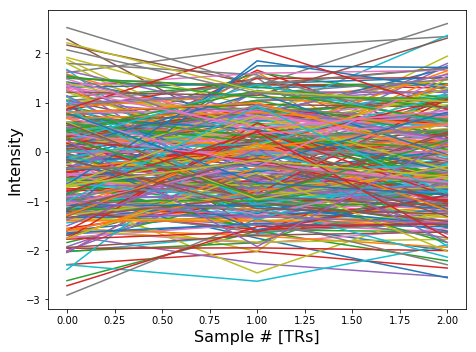

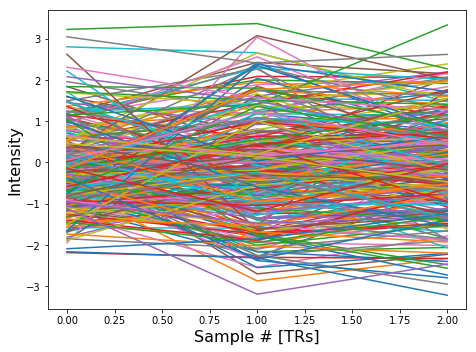

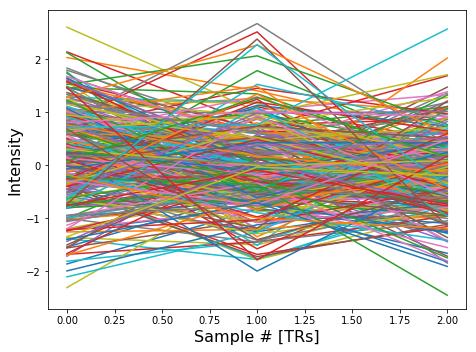

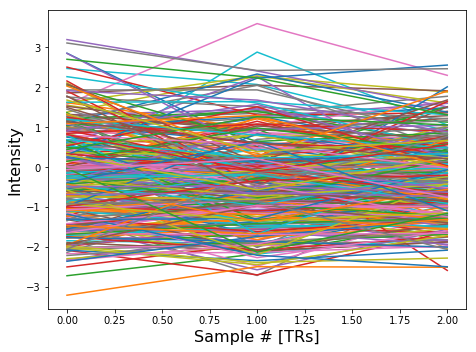

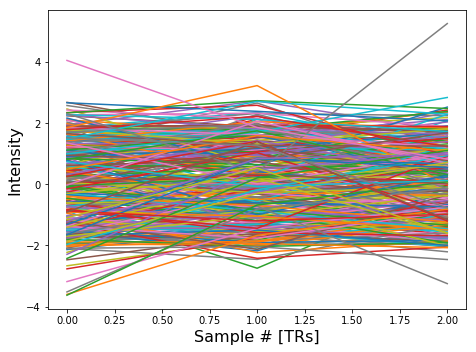

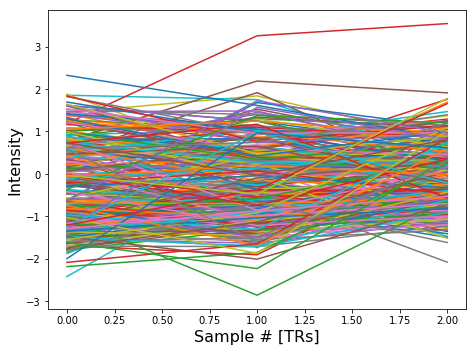

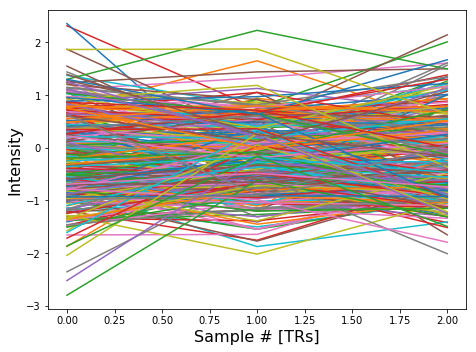

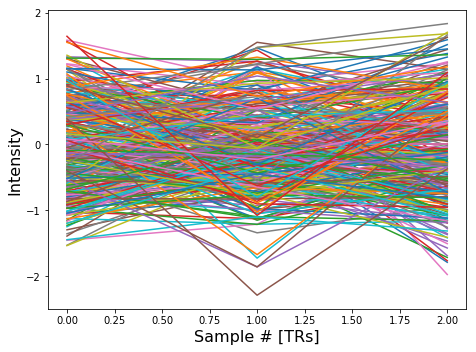

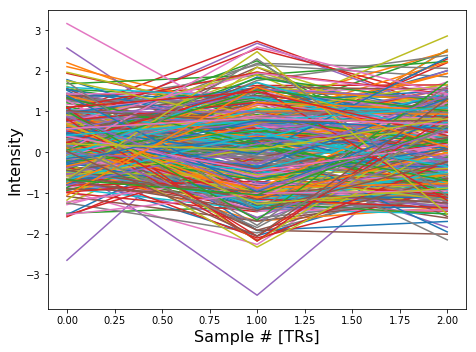

In [136]:
for v in voxel_responses[i][region][hemisphere]['octopus']:
    plt.figure(figsize=(7, 5))
    plt.plot(v)
    plt.xlabel('Sample # [TRs]', fontsize=16)
    plt.ylabel('Intensity', fontsize=16)
    
    plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

This puts all the relevant data into an input matrix for PCA. Currently, the data is organized by time x voxels x category.

In [157]:
### Data is in form of time x voxels x images
### Join regions of brain data together along voxels dimension
mat = np.zeros((1, 339))
for i in patients:
    ### 33 second rest at beginning + (9 second images * 55 images) + 6 second rest at end = 534 seconds
    ### 534 seconds / 3 seconds per slice = 178 slices
    ### Eliminated rest slices (11 at beginning, 2 at end) -> 165 points along time dimension
#     data[i] = defaultdict(list)
    for region in regions:
        for hemisphere in hemispheres:
            print(len(voxel_responses[i][region][hemisphere]))
            for category, voxels in voxel_responses[i][region][hemisphere].items():
                for v in voxels:
                    for j in np.arange(3):
                        data = np.array(v[j])
                        data = data.reshape((1, 339))
                        mat = np.vstack((mat, data))
                

147


This is the beginning of doing PCA on the data. Since the voxel responses are stored along the columns, we must demean those first, then do the Singular Value Decomposition (SVD), from the most significant singular values choose the PC's that we want, then project our data onto there.

In [158]:
# Get rid of 0's at beginning
cleaned_mat = mat[1:]
print(mat.shape)
### Since voxels are along along horizontal dimension, data is stored in columns
mean = np.mean(cleaned_mat, axis = 0)
processed_mat = cleaned_mat - mean

(3889, 339)


In [159]:
[u,s,v] = np.linalg.svd(processed_mat, full_matrices=False)

Text(0.5,1,'Singular Values')

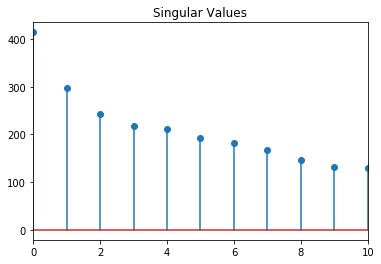

In [160]:
plt.stem(s)
plt.xlim([0, 10])
plt.title("Singular Values")

As we can see, 3 principal coponents should do the trick.

Text(0.5,1,'3 Principal Components')

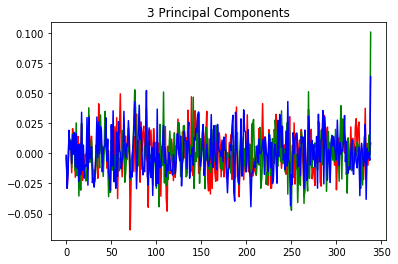

In [133]:
pca_vec1 = u[0]
pca_vec2 = u[1]
pca_vec3 = u[2]
plt.plot(pca_vec1, color = "red")
plt.plot(pca_vec2, color = "green")
plt.plot(pca_vec3, color = "blue")
plt.title("3 Principal Components")

In [141]:
proj = np.dot(processed_mat, u[0:3].T)
print(proj.shape)

(3888, 3)


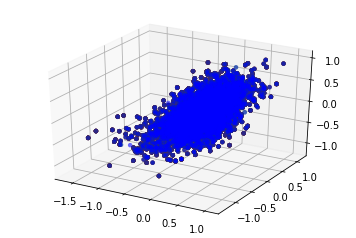

In [154]:
from pylab import *
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_color_cycle('rgb')
for i in np.arange(0, 3889, 147):
    ax.scatter(proj[:i,0], proj[:i,1], proj[:i,2], edgecolor='none')

The dimensionality reduction worked pretty well, though the data points are pretty close to each other. Unfortunately, matplotlib doesn't let me separate the points into ~50 colors (the number of categories), so I'm unable to see the separation of categories.

## Conclusion/Discussion

Unfortunately, due to time constraints and the tremendous amount of time I spent researching libraries to actually get the information I wanted from the fMRI data, I was unable to complete the classification steps. The math was the easy part, but massaging the data into how I wanted it was a bit frustrating and took way longer than I expected it to take. However, I will illustrate what I would have done if I had more time/resources:

Once PCA was done, I would separate the points into their categories and visualize how close the concepts are. This is similar to Jack's reserach where he found that similar topics have similiar BOLD signatures. Once there, I would then project the test and "imagination" datapoints onto the principal components and observe where it falls in the scatterplot. For example, I would think that, if everything was done correctly, that a brand new category for the model, such as "donkey", would have it's own BOLD signature, but once projected, would appear close to where the other animals are.

In addition, the data I worked with was only a certain section of one subject's brain, while the entire dataset contains all the main portions of the visual cortex among 5 different subjects. However, when I attempted to run this, it took way too long. I would be interested to see how that would change my results; I would assume that given more data, we would get more variability, which would help our model be more generalizable. I definitely plan to continue to tinker with this code after the course if finished because I am curious to see if things would work out as cleanly as I would have hoped.

With regards to what I can conclude from what we did: clearly, I don't believe the amount of data I used was enough. While I did get a good spread of variance among the different topics, they tended to cluster in one big chunk. I would think that adding more data (other brain areas, the other subjects), would definitely help vary the data a bit and create distinct regions in the subspace. One thing that can be noticed, however, is that the BOLD sigatures for the same topic tended to be similar, while those for different categories were differentiable. This hints at the possibility of nicely separated clusters as well.

## References

1. Horikawa, T. & Kamitani, Y. (2017). Generic decoding of seen and imagined objects using hierarchical visual features. Nature Communications 8:15037. doi:10.1038/ncomms15037

2. Haxby, J. V. et al. Distributed and overlapping representations of faces and object in ventral temporal cortex. Science 293, 2425–2430 (2001).

3. Kamitani, Y. & Tong, F. Decoding the visual and subjective contents of the human brain. Nat. Neurosci. 8, 679–685 (2005).

4. Harrison, S. A. & Tong, F. Decoding reveals the contents of visual working memory in early visual areas. Nature 458, 632–635 (2009).

5. Albers, A. M., Kok, P., Toni, I., Dijkerman, H. C. & De Lange, F. P. Shared representations for working memory and mental imagery in early visual cortex. Curr. Biol. 23, 1–5 (2013).

6. Xing, Y., Ledgeway, T., McGraw, P. V. & Schluppeck, D. Decoding working memory of stimulus contrast in early visual cortex. J. Neurosci. 33, 10301–10311 (2013).

7. Reddy, L., Tsuchiya, N. & Serre, T. Reading the mind's eye: decoding category information during mental imagery. Neuroimage 50, 818–825 (2010).

8. Horikawa, T., Tamaki, M., Miyawaki, Y. & Kamitani, Y. Neural decoding of visual imagery during sleep. Science 340, 639–642 (2013).

9. Naselaris, T., Prenger, R. J., Kay, K. N., Oliver, M. & Gallant, J. L. Bayesian reconstruction of natural images from human brain activity. Neuron 63, 902–915 (2009).

10. Naselaris, T., Olman, C. A., Stansbury, D. E., Ugurbil, K. & Gallant, J. L. A voxel-wise encoding model for early visual areas decodes mental images of remembered scenes. Neuroimage 105, 215–228 (2015).

## Supplemental Work

These are remnants/snippets of things that either helped me write the code or were never finished.

In [162]:
# Grabbing data from "imagination datasets"

imagery_tests = {1: 8, 2: 8, 3: 4}
imagery_runs = {1 : [8, 8, 4]}
# Map of patient to labels
labels = {}

for i in patients:
    labels[i] = {}
    for region in regions:
        labels[i][region] = {}
        for hemisphere in hemispheres:  
            labels[i][region][hemisphere] = {}
            for training in np.arange(1, imagery_tests[i] + 1):
                labels[i][region][hemisphere][training] = {}
                for run in np.arange(1, imagery_runs[i][training - 1] + 1):
                    labels[i][region][hemisphere][training][run] = {}
                    with open('./mri-images/sub-%02d/ses-imageryTest%02d/func/sub-%02d_ses-imageryTest%02d_task-imagery_run-%02d_events.tsv' % (i, training, i, training, run),'r') as dataset:
                        data = csv.reader(dataset, delimiter='\t')
                        for row in data:
                            slice_num = row[0]
                            valid = row[3] ## Checks if rest or stimulus
                            stim_id = row[4]
                            stim_id = stim_id[:7] ## Extract category from 'category.picture'
                            if valid == 'stimulus':
                                # Convert from time to slice number (fMRI data stored this way)
                                slice_num = int(slice_num) // 3
                                labels[i][region][hemisphere][training][run][slice_num] = stim_id

In [ ]:
for i in patients:
    for region in regions: 
        for hemisphere in hemispheres: 
#             for training in np.arange(1, num_training[i] + 1):
            for training in np.arange(1, 2):
#                 for run in np.arange(1, runs[i][training - 1] + 1):
                for run in np.arange(1, 2):
                    for category, voxels in voxel_responses[i][region][hemisphere][training][run].items():
                        plt.figure(figsize=(7, 5))
                        plt.plot(voxels)
                        plt.xlabel('Sample # [TRs]', fontsize=16)
                        plt.ylabel('Intensity', fontsize=16)
                        plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
                        plt.title("Subject %s's %s %s Response to %s" % (i, hemisphere, region, category))

In [161]:
a = np.array([[1, 2, 3],
              [4, 5, 6]])

b = np.array([[7, 8, 9],
             [10, 11, 12]])

np.hstack((a, b))

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

In [162]:
np.vstack((a, b))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [166]:
print(a.shape, b.shape)

(2, 3) (2, 3)


In [190]:
a = np.array([[1], [2], [3]])
b = np.array([[4], [5], [6]])

In [191]:
np.vstack((a, b))

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [138]:
labels = {}
for i in np.arange(1, 2):
    
    labels[i] = []
    with open('./mri-images/sub-0%s/ses-perceptionTraining02/func/sub-0%s_ses-perceptionTraining02_task-perception_run-01_events.tsv' % (i, i),'r') as dataset:
        data = csv.reader(dataset, delimiter='\t')
#         data = pd.read_csv(dataset, sep="\t")
#         stim_ids = data["stim_id"]
#         print(stim_ids)
        for row in data:
#             print(row)
            valid = row[3] ## Checks if rest or stimulus
            stim_id = row[4]
            stim_id = stim_id[:7] ## Extract category from 'category.picture'
            if valid == 'stimulus':
                labels[i].append(stim_id)

In [137]:
for i in np.arange(1, 2):
    print(labels[i])
unique = set(labels[1])

['4284002', '4320973', '7734744', '7734744', '2769748', '2769748', '4272054', '2480855', '4373894', '2885462', '3602883', '3665924', '2005790', '4555897', '2882647', '4154565', '1855672', '4123740', '4409806', '1770393', '4591713', '3746005', '3467796', '3400231', '3544143', '3359137', '3496296', '3483823', '3886762', '3743279', '3792782', '3445777', '1726692', '3607659', '4612026', '4612026', '2346627', '1963571', '3038480', '1833805', '3512147', '2799175', '2799175', '3924679', '3085013', '3646296', '4168199', '4168199', '1772222', '4255586', '3079230', '1944390', '2814860', '1768244', '2236241']
